In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# 데이터를 불러오기
data = np.load('/content/drive/MyDrive/지윤/new100/npy/data_001.npy')
target = np.load('/content/drive/MyDrive/지윤/new100/npy/target_001.npy')

num_classes = 100
target_tmp = to_categorical(target)

# 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(data, target_tmp, test_size=0.2, random_state=42, stratify=target)

# 데이터셋 확인
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (16000, 224, 224, 3)
Test set size: (4000, 224, 224, 3)


## ResNet152V2

In [ ]:
# 모델 설계
import tensorflow as tf
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization


# 사전 학습된 ResNet50 모델 로드 (최상위 레이어 제외)
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D()) # dense 위로 올려봄
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# 일부 층은 훈련되지 않도록 설정 (동결)
for layer in base_model.layers:
    layer.trainable = False

# 모델 컴파일
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 옵션 지정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    #'/content/drive/MyDrive/지윤/new/model/nn1_{epoch:02d}_{val_loss:.4f}_{val_accuracy:.4f}.hdf5',
    '/content/drive/MyDrive/지윤/new100/model/100_model8.hdf5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto')

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 batch_normalization_2 (Bat  (None, 7, 7, 2048)        8192      
 chNormalization)                                                
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)              

# 모델 학습

In [ ]:
# 모델 학습
history=model.fit(X_train, y_train,
                  epochs=100,
                  batch_size=64,
                  callbacks=[checkpoint, early_stopping],
                  validation_split=0.2)

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 4.5160 - accuracy: 0.0407
Epoch 1: val_loss improved from inf to 4.09159, saving model to /content/drive/MyDrive/지윤/new100/model/100_model8.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 76s 338ms/step - loss: 4.5160 - accuracy: 0.0407 - val_loss: 4.0916 - val_accuracy: 0.2384
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 3.9290 - accuracy: 0.1474
Epoch 2: val_loss improved from 4.09159 to 3.28246, saving model to /content/drive/MyDrive/지윤/new100/model/100_model8.hdf5
200/200 [==============================] - 63s 314ms/step - loss: 3.9290 - accuracy: 0.1474 - val_loss: 3.2825 - val_accuracy: 0.4078
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 3.2730 - accuracy: 0.2551
Epoch 3: val_loss improved from 3.28246 to 2.50637, saving model to /content/drive/MyDrive/지윤/new100/model/100_model8.hdf5
200/200 [==============================] - 63s 313ms/step - loss: 3.2730 - accuracy: 0.2551 - val_loss: 2.5064 - val_accuracy: 0.5075
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 2.7877 - accuracy: 0.3362
Epoch 4: val_loss improved from 2.50637 to 2.05163, sav

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy * 100:.2f}%")

125/125 [==============================] - 16s 107ms/step - loss: 0.7000 - accuracy: 0.8055
Test accuracy: 80.55%


Minimum Validation Loss: 0.8920


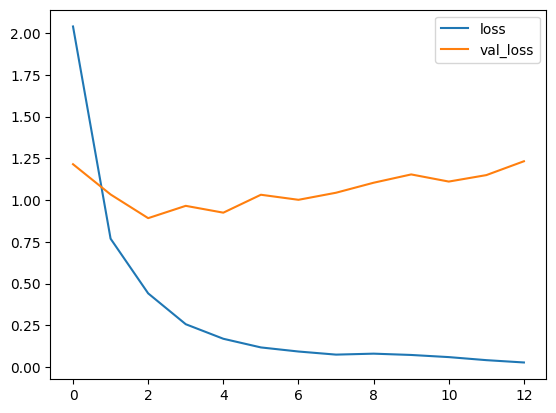

In [ ]:
# 그래프 model6
import matplotlib.pyplot as plt
import pandas as pd
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))
# 완전 과대적합임을 알 수 있음
# dropout 추가 및 학습률 조정

Minimum Validation Loss: 0.7707


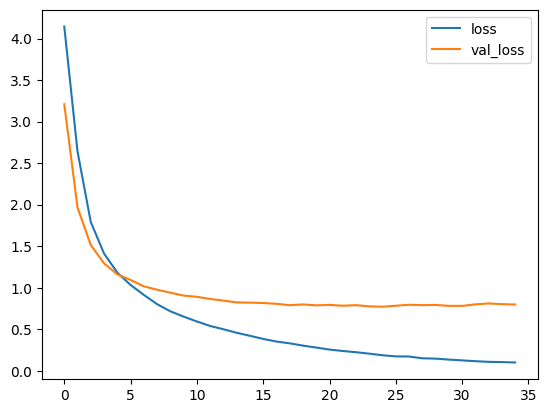

In [ ]:
# 그래프 model7
import matplotlib.pyplot as plt
import pandas as pd
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))
# 전보다 과적합은 잡혔지만 여전히 과적합
# pooling을 dense위로 올려봄

Minimum Validation Loss: 0.7485


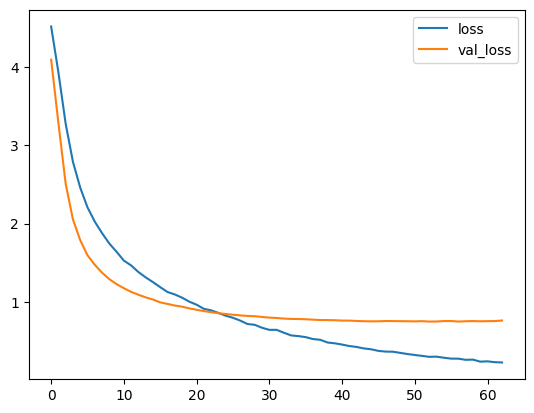

In [ ]:
# 그래프 model8
import matplotlib.pyplot as plt
import pandas as pd
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))
# 과적합을 잡았지만 여전히 과적합
# 25 저 지점을 저장해놓고 추가 학습을 시켜야하나?

# 클래스 별 정확도

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix

#model = load_model('/content/drive/MyDrive/지윤/new100/model/100_model8.hdf5')

y_test_labels = np.argmax(y_test, axis=1)
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# 클래스별 정확도 계산
class_accuracies = {}

# 혼동 행렬 생성
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

# 각 클래스별로 정확도 계산
for i in range(conf_matrix.shape[0]):
    true_positives = conf_matrix[i, i]
    total_samples = np.sum(conf_matrix[i, :])
    accuracy = true_positives / total_samples
    class_accuracies[i] = accuracy

# 클래스 이름과 인덱스를 로드
class_indices_df = pd.read_csv('/content/drive/MyDrive/지윤/new100/npy/class_001.csv')

# 클래스 인덱스와 정확도를 매핑
accuracies_list = []
for class_index, accuracy in class_accuracies.items():
    class_name = class_indices_df[class_indices_df['Class Index'] == class_index]['Class Name'].values[0]
    accuracies_list.append([class_name, class_index, accuracy])

# 데이터프레임 생성
accuracies_df = pd.DataFrame(accuracies_list, columns=['Class Name', 'Class Index', 'Accuracy'])
accuracies_df
# 천도복숭아 복숭아 ^^

125/125 [==============================] - 17s 108ms/step


,Class Name,Class Index,Accuracy
0,가지,0,0.825
1,감자스프,1,0.925
2,감,2,0.800
3,게맛살,3,0.875
4,거봉포도,4,0.875
...,...,...,...
95,후라이드치킨,95,0.975
96,후랑크소시지,96,0.800
97,호두파이,97,0.800
98,떡볶이,98,0.875


In [ ]:
# 데이터프레임 저장
accuracies_df.to_csv('/content/drive/MyDrive/지윤/new100/accuracy_df.csv', index=False)

print("성공적으로 저장되었습니다!")

성공적으로 저장되었습니다!
